In [1]:
suppressPackageStartupMessages({
    library(limma)
    library(ggplot2)
    library(patchwork)
    library(ggsci)
    library(imputeLCMD)
    library(rrcovNA)

})

options(warn = -1)


impute.perseus <- function(x, width=0.3, shift=1.8) {
  # distributions are induced by measured values in each sample
  data.mean <- colMeans(x, na.rm = TRUE)
  data.sd <- matrixStats::colSds(x, na.rm = TRUE)
  n <- nrow(x)
  z <- rmvnorm(n, mean = data.mean - shift*data.sd , sigma = diag(data.sd*width))
  x[is.na(x)] <- z[is.na(x)]
  return(x)
}

fig.size <- function (height, width) {
    options(repr.plot.height = height, repr.plot.width = width, repr.plot.res = 200)
}

devtools::load_all("/stornext/General/data/academic/lab_davis/prot/benchmarking/msImpute/")


ℹ Loading msImpute



In [2]:
data <- read.delim("/stornext/General/data/academic/lab_davis/prot/benchmarking/PXD002370/txt/evidence.txt", stringsAsFactors = FALSE)

table(data$Type)

# data <- data[grep("CON_|REV_", data$Leading.razor.protein, invert=TRUE),]
data <- data[data$Charge > 1,]
data$PeptideID <- paste0(data$Modified.sequence, data$Charge)
data$matrix.row.id <- paste(data$PeptideID, data$Leading.Razor.Protein, sep ="_")


genes <- data[,c("PeptideID","matrix.row.id", "Leading.Razor.Protein")]
genes <- genes[!duplicated(genes),]


y <- evidenceToMatrix(data) # [grepl("MULTI-MSMS|MULTI-SECPEP", data$Type),]

genes <- genes[match(rownames(y), genes$PeptideID),]

#table(grepl("ups", data$Leading.Razor.Protein))


        MSMS  MULTI-MATCH   MULTI-MSMS MULTI-SECPEP 
        6898        12555        65714         9150 

In [3]:
y_dda <- log2(y)
y <- log2(y)

In [4]:
rownames(y) <- genes$matrix.row.id[match(rownames(y), genes$PeptideID)]
rownames(y_dda) <- genes$matrix.row.id[match(rownames(y_dda), genes$PeptideID)]

In [5]:

keep3 <- (!grepl("CON__|REV__", genes$Leading.Razor.Protein))
keep4 <- (!grepl("[a-z]+", genes$PeptideID))

y_dda <- y_dda[keep3&keep4,]
# y <- normalizeBetweenArrays(log2(y[keep1&keep2,]), method = "quantile")
y <- y[keep3&keep4,]


targets <- read.delim("/stornext/General/data/academic/lab_davis/prot/benchmarking/PXD002370/experimentalDesignTemplate.txt")
group <- as.factor(gsub("(.*)-R[123]", "\\1", targets$Experiment))

design <- model.matrix(~ group)

In [6]:
y_dda <- y_dda[rowSums(!is.na(y_dda)) >= 4,]

### imputation (barycenter + SOTA methods)

In [7]:
fig.size(4, 6)

y_msImpute <- msImpute(y_dda, 
                       rank.max = 2,
                       method = "v2-mnar",
                       group = group)


Running msImpute version 2

Estimate distribution under MAR assumption

rank is 2

computing lambda0 ...

lambda0 is 4.14291937968878

fit the low-rank model ...

model fitted. 
Imputting missing entries ...

Imputation completed

Compute barycenter of MAR and NMAR distributions v2-mnar



In [8]:
##############################
#### Analysis in MSstats
##############################

##############################
## Load MSstats package
##############################
library(MSstats)

##############################
## Read MaxQuant report
##############################
# read in proteinGroups file, in order to use protein ids
proteinGroups<-read.table("/stornext/General/data/academic/lab_davis/prot/benchmarking/PXD002370/txt/proteinGroups.txt", sep="\t", header=TRUE)

# Read in MaxQuant file: evidence.txt
infile <- read.table("/stornext/General/data/academic/lab_davis/prot/benchmarking/PXD002370/txt/evidence.txt", sep="\t", header=TRUE)

# Read in annotation including condition and biological replicates
annot <- data.frame('Raw.file' = infile$Raw.file)
annot <- annot[!duplicated(annot$Raw.file),, drop = FALSE]
annot$Experiment <- targets$Experiment[match(annot$Raw.file, targets$Name)]
annot$Condition <- gsub('(.*)-(.*)', '\\1', annot$Experiment)
annot$BioReplicate <- gsub('(.*)-R([1-3])', '\\2', annot$Experiment)
annot$IsotopeLabelType <- 'L'


##############################
## Make MSstats required format
##############################
quant <- MaxQtoMSstatsFormat(evidence=infile, annotation=annot, proteinGroups=proteinGroups,
                             useUniquePeptide = TRUE,
                             summaryforMultipleRows = max,
                             removeProtein_with1Peptide=TRUE)

head(quant)


##############################
## dataProcess
## including Normalization, decide censored cutoff, protein-level summarization
##############################

## censoredInt='NA' for MaxQuant
processed.quant <- dataProcess(quant,
                               normalization = 'equalizeMedians',
                               summaryMethod="TMP",
                               cutoffCensored="minFeature",
                               censoredInt="NA",
                               MBimpute=TRUE,
                               maxQuantileforCensored=0.999)


y_msstats <- processed.quant$ProcessedData
y_msstats$peptide_id <- paste0(y_msstats$PEPTIDE,'_', y_msstats$PROTEIN)
y_msstats <- y_msstats[,c('peptide_id', 'originalRUN', 'ABUNDANCE')]
y_msstats <- tidyr::spread(y_msstats, 'originalRUN', 'ABUNDANCE')
rownames(y_msstats) <- y_msstats$peptide_id
y_msstats$peptide_id <- NULL

all(colnames(y_msstats) == colnames(y_dda))


featurenames <- gsub('^_','', rownames(y_dda))
target_hits <- grep('upsedyp', featurenames, value = TRUE)
length(target_hits)



** + Contaminant, + Reverse, + Only.identified.by.site, proteins are removed.

** Peptide and charge, that have 1 or 2 measurements across runs, are removed.

** 454 proteins, which have only peptide and charge in a protein, are removed among 2218 proteins.



,ProteinName,PeptideSequence,PrecursorCharge,FragmentIon,ProductCharge,IsotopeLabelType,Condition,BioReplicate,Run,Intensity
,<fct>,<fct>,<int>,<lgl>,<lgl>,<chr>,<chr>,<chr>,<fct>,<dbl>
1,O00762upsedyp|UBE2C_HUMAN_upsedyp,FITPCYHPNVDTQGNICIDIIK,3,NA,NA,L,E,1,QEx2_000088,7127700
2,O00762upsedyp|UBE2C_HUMAN_upsedyp,GISAFPESDNIFK,2,NA,NA,L,E,1,QEx2_000088,44977000
3,O00762upsedyp|UBE2C_HUMAN_upsedyp,ISIEFPSGYPYNAPTVK,2,NA,NA,L,E,1,QEx2_000088,27984000
4,O00762upsedyp|UBE2C_HUMAN_upsedyp,WSAIYDVR,2,NA,NA,L,E,1,QEx2_000088,39495000
5,O00762upsedyp|UBE2C_HUMAN_upsedyp,WVGTIHGAAGTVYEDIR,3,NA,NA,L,E,1,QEx2_000088,21520000
6,O76070upsedyp|SYUG_HUMAN_upsedyp,EDIRPSAPQQEGEASK,3,NA,NA,L,E,1,QEx2_000088,12685000


** Log2 intensities under cutoff = 16.884  were considered as censored missing values.

** Log2 intensities = NA were considered as censored missing values.

** Use all features that the dataset origianally has.



                       
  Summary of Features :
                         count
# of Protein              1764
# of Peptides/Protein     2-78
# of Transitions/Peptide   1-1
                      
  Summary of Samples :
                           D E
# of MS runs               3 3
# of Biological Replicates 3 3
# of Technical Replicates  1 1



 Summary of Missingness :


  # transitions are completely missing in at least one of the conditions : 153


    -> GGPIDGTYR_2_NA_NA, EQIQDMGIVDIFSPEK_2_NA_NA, EVPINTIIFM(ox)GR_2_NA_NA, FATTFYQHIADSK_2_NA_NA, TPSDKPVAHVVANPQAEGQIQWINR_4_NA_NA ...


  # run with 75% missing observations: 0



 == Start the summarization per subplot...



  |======================================================================| 100%



 == the summarization per subplot is done.



[1] TRUE

[1] 252

In [9]:
y_MLE <- impute.wrapper.MLE(y_dda)
y_impSeq <- impSeq(y_dda[(rowSums(!is.na(y_dda)) >= 2),])
y_knn <- impute.wrapper.KNN(y_dda[(rowSums(!is.na(y_dda)) >= 2),], K = 15)




y_perseus <- impute.perseus(y_dda)



# pcv <- plotCV2(limma::normalizeBetweenArrays(y_perseus,
#                                              method = 'quantile'), 
#                main = "perseus")

y_qrilc <- impute.QRILC(y_dda, 1)[[1]]



sOa_imps <- readRDS("/stornext/Home/data/allstaff/h/hediyehzadeh.s/softImpute_low_rank_experimentation/impute_PXD002370_sOa_filter4obs_noNorm.rds")
names(sOa_imps) <- c("RF","Mice","EM","BPCA","LLS")

sOa_imps <- sOa_imps[c("RF","Mice","EM","BPCA")]

z <- m <- rownames(sOa_imps[[1]])


rowsname <- rownames(y_dda)[!(rowSums(is.na(y_dda)) >=2 )]

mats <- list(
             "KNN"= y_knn,
             "impSeq" = y_impSeq,
             "barycenter" = y_msImpute,
             "MSstats_AFT" = y_msstats,
             "baseline" = y_dda)


mats <- c(sOa_imps, mats)

Cluster size 12827 broken into 2840 9987 
Cluster size 2840 broken into 857 1983 
Done cluster 857 
Cluster size 1983 broken into 672 1311 
Done cluster 672 
Done cluster 1311 
Done cluster 1983 
Done cluster 2840 
Cluster size 9987 broken into 2457 7530 
Cluster size 2457 broken into 699 1758 
Done cluster 699 
Cluster size 1758 broken into 636 1122 
Done cluster 636 
Done cluster 1122 
Done cluster 1758 
Done cluster 2457 
Cluster size 7530 broken into 3428 4102 
Cluster size 3428 broken into 1006 2422 
Done cluster 1006 
Cluster size 2422 broken into 1130 1292 
Done cluster 1130 
Done cluster 1292 
Done cluster 2422 
Done cluster 3428 
Cluster size 4102 broken into 1912 2190 
Cluster size 1912 broken into 1042 870 
Done cluster 1042 
Done cluster 870 
Done cluster 1912 
Cluster size 2190 broken into 1024 1166 
Done cluster 1024 
Done cluster 1166 
Done cluster 2190 
Done cluster 4102 
Done cluster 7530 
Done cluster 9987 


### Differential expression

In [10]:
n_ups <- 500
fdr_thresh <- 0.05

topN <- list()
fullTables <- list()
fullTables2 <- list()
for(i in seq_along(mats)){
  message("processing ", names(mats)[i])
   if(names(mats)[i] != "MSstats_AFT"){
     E <- normalizeBetweenArrays(mats[[i]], method = "quantile")
   }else{
     E <- mats[[i]]
   }
   fit <- lmFit(E, design = design)

   fit <- eBayes(fit)
   print(summary(decideTests(fit)))

  tp <- topTable(fit, coef=ncol(fit), number = Inf, p.value = 1)
  tp$de <- ifelse(tp$adj.P.Val < fdr_thresh,1,0)
  
  
  rownames(tp) <- gsub('^_','', rownames(tp))
  tp$isUPS <- ifelse((rownames(tp) %in% target_hits) , 1,0)
  
  tp$TP <- ifelse(tp$de==1 & tp$isUPS==1,1,0) # a ups called DE is a true positive
  tp$FN <- ifelse(tp$de==0 & tp$isUPS==1,1,0) # a ups called not DE is a false negative
  tp$FN_unestim <- ifelse(is.na(tp$adj.P.Val) & tp$isUPS==1,1,0)
  tp$fd <- ifelse(tp$isUPS==0 & tp$de ==1 ,1,0) # & !complete.cases(y_dda[match(rownames(tp), rownames(y_dda)),])
  tp$FDR <- cumsum(tp$fd)/cumsum(tp$de)
  topN[[names(mats)[i]]] <- data.frame(N=seq_len(n_ups),
                                       numUPS=cumsum(tp$isUPS)[seq_len(n_ups)],
                                       #numUPS=cumsum(tp$TP)[seq_len(n_ups)],
                                       FDR=tp$FDR[seq_len(n_ups)],
                                       nominalFDR= ifelse(seq_len(n_ups) == which(tp$adj.P.Val > fdr_thresh)[1],1,0),
                                       method=names(mats)[i])
  


  fullTables[[names(mats)[i]]] <- data.frame(

    predictions = -log10(tp$P.Value),
    labels = tp$isUPS
    
    
    
    )
  
  
  TP_total = sum(tp$TP, na.rm = TRUE)
  FN_total = sum(tp$FN, na.rm = TRUE)
  FN_unestim_total = sum(tp$FN_unestim, na.rm = TRUE)
  if(names(mats)[i] == "MSstats_AFT"){
    FN_unestim_total = length(target_hits) - sum(TP_total, FN_total)
  }
  fullTables2[[names(mats)[i]]] <- data.frame(

    
    TP = cumsum(tp$TP),
    FP = cumsum(tp$fd),
    TP_total = sum(tp$TP, na.rm = TRUE),
    FP_total = sum(tp$fd, na.rm = TRUE),
    FN_total = sum(tp$FN, na.rm = TRUE),
    FN_unestim_total = FN_unestim_total
    
    

    
    )
}


topN <- do.call(rbind, topN)
fullTables <- do.call(rbind, fullTables)
fullTables$method <- gsub("(.*)\\.(.*)","\\1", rownames(fullTables))
fullTables$predictions[is.na(fullTables$predictions)] <- 0


fullTables2 <- do.call(rbind, fullTables2)
fullTables2$method <- gsub("(.*)\\.(.*)","\\1", rownames(fullTables2))

processing RF



       (Intercept) groupE
Down             0    149
NotSig           0  12628
Up           12827     50


processing Mice



       (Intercept) groupE
Down             0    157
NotSig           0  12609
Up           12827     61


processing EM



       (Intercept) groupE
Down             0    137
NotSig           0  12647
Up           12827     43


processing BPCA



       (Intercept) groupE
Down             0    151
NotSig           0  12623
Up           12827     53


processing KNN



       (Intercept) groupE
Down             0    126
NotSig           0  12659
Up           12827     42


processing impSeq



       (Intercept) groupE
Down             0    180
NotSig           0  12563
Up           12827     84


processing barycenter



       (Intercept) groupE
Down             0    152
NotSig           0  12629
Up           12827     46


processing MSstats_AFT



       (Intercept) groupE
Down             0    150
NotSig           0  12943
Up           13313     67


processing baseline



       (Intercept) groupE
Down             0    160
NotSig           0  12588
Up           12827     79


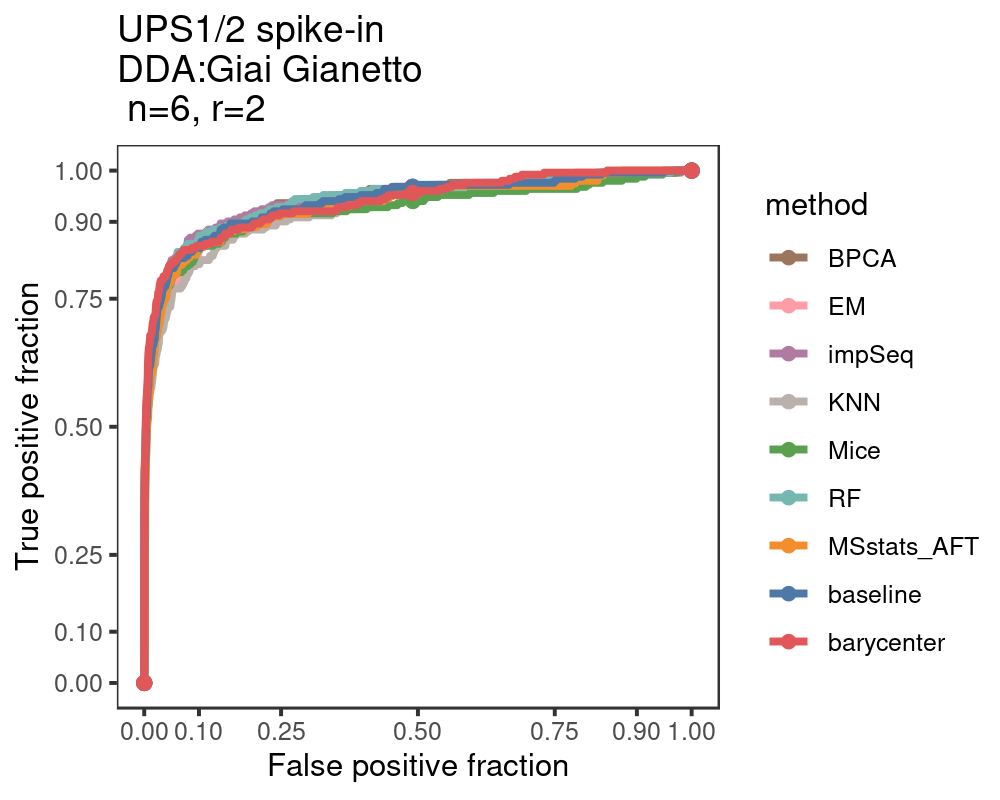

In [11]:
fig.size(4, 5)

library(plotROC)
library(ggthemes)


col_pal <- tableau_color_pal(palette = "Tableau 10", direction = -1)(9)
col_pal[col_pal == "#EDC948"] = "#BAB0AC"
names(col_pal) <- c("BPCA", "EM", "impSeq", "KNN", "Mice", "RF","barycenter","MSstats_AFT","baseline")

fullTables$method <- factor(fullTables$method, 
                             levels = c("BPCA", "EM", "impSeq", "KNN", "Mice", "RF",
                                        "MSstats_AFT",
                                        "baseline","barycenter"))

p2 <- ggplot(fullTables, aes(m = predictions, d = labels, group = method, color = method))+ geom_roc(n.cuts=3,labels=FALSE) +
   style_roc(guide=FALSE) + 
  scale_color_manual(values = col_pal) +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(), 
       # legend.position = 'None'
       )
  






fullTables2$method <- factor(fullTables2$method, 
                             levels = c("BPCA", "EM", "impSeq", "KNN", "Mice", "RF",
                                        "MSstats_AFT",
                                        "baseline","barycenter"))


dataset_name = 'PXD002370'

print(p2 + labs(title = "UPS1/2 spike-in \nDDA:Giai Gianetto\n n=6, r=2"))


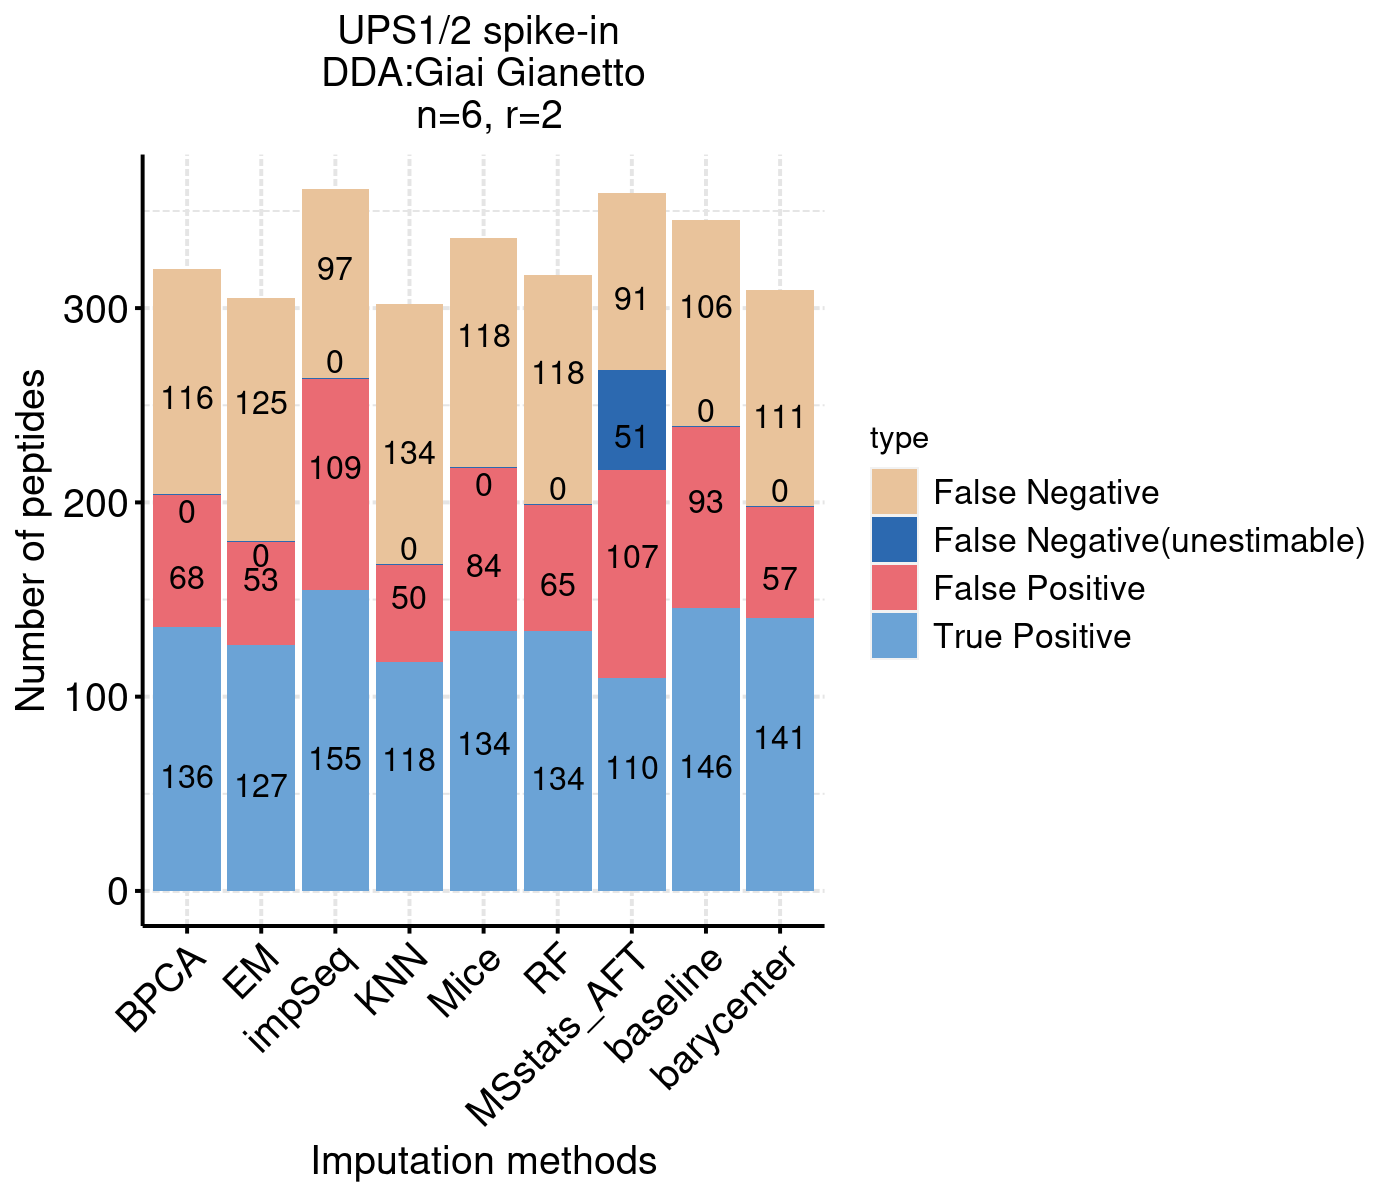

In [12]:
fig.size(6,7)
# Barplot of True positive, false positives and false negatives for all methods at FDR 0.05

ggdat <- fullTables2[,grep("method|total", colnames(fullTables2))]
ggdat <- ggdat[!duplicated(ggdat$method),]
colnames(ggdat) <- gsub("_total", "", colnames(ggdat))


ggdat <- reshape2::melt(ggdat, id = "method")
ggdat$method <- factor(ggdat$method, 
                             levels = c("BPCA", "EM", "impSeq", "KNN", "Mice", "RF","MSstats_AFT","baseline","barycenter"))


ggdat$variable <- gsub("TP", "True Positive", ggdat$variable)
ggdat$variable <- gsub('FN_unestim', 'False Negative(unestimable)', ggdat$variable)
ggdat$variable <- gsub("FP", "False Positive", ggdat$variable)
ggdat$variable <- gsub("FN", "False Negative", ggdat$variable)



# png(file = "~/barplot_PXD002370.png",
#     width=6,height=5,units="in",res=1200)



p <- ggplot(ggdat, aes(x=method, y = value, fill = variable, label=value)) +
  geom_bar(stat = "identity", position="stack") +
  # geom_text(position = position_stack(vjust = 0.5)) +
  ggrepel::geom_text_repel(size = 4, 
            position = position_stack(vjust = 0.5), direction = "y", 
            box.padding = unit(0.01, "lines")) + 
  xlab('Imputation methods') + ylab('Number of peptides') + 
  labs(fill="type", title = "UPS1/2 spike-in \nDDA:Giai Gianetto\n n=6, r=2") + 

  scale_fill_manual(values = c('False Negative(unestimable)' = "#2c69b0",
                               'False Negative' = "#e9c39b" ,
                               'True Positive' = "#6ba3d6", 
                               'False Positive' = "#ea6b73")) + 
  theme(axis.text.y = element_text(hjust = 1, size=14, color = "black"),
      axis.text.x = element_text(angle = 45, vjust = 1, hjust=1, size = 14, color= "black"),
                strip.text.x = element_text(size=14),
                plot.title = element_text(hjust = 0.5, size = 14),
      axis.title=element_text(size=14),
      panel.background = element_rect(fill = "white",
                                colour = "white",
                                size = 3, linetype = "solid"),
  panel.grid.major = element_line(#size = 3,
                                  linetype = 'longdash',
                                colour = "grey90"), 
  panel.grid.minor = element_line(#size = 3, 
                                  linetype = 'longdash',
                                colour = "grey90"),
      axis.line = element_line(colour = "black"),
      axis.ticks = element_line(colour = "black"),
      legend.text=element_text(size=12)
                #legend.position = "none"
     ) 

# print(p)
# dev.off()
p

No NaN EBMs detected. Peptides are missing evenly across samples.

Switchted to 'hvp' method as final msImpute features




FALSE  TRUE 
12327   500 

png 
  2

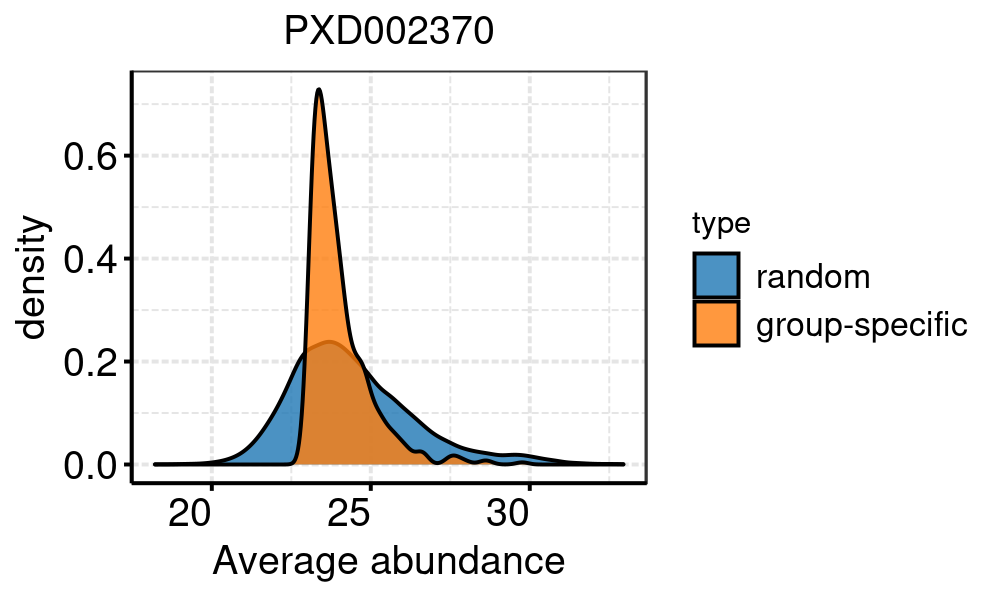

In [13]:
fig.size(3,5)


# Visualization of the ebm metric for assessment of missing types

hdp <- selectFeatures(y_dda[rowSums(!is.na(y_dda)) >= 4,],
                      method="ebm", group = group)

#hdp
table(hdp$msImpute_feature) # msImpute features are peptides that exhibit condition-specific missing values

ebms <- hdp$EBM
ebms[hdp$msImpute_feature] <- -1
# hist(ebms)
# plot(hdp$AveExpr, ebms, pch = 16, cex = 0.3)



library(ggExtra)

ggdat <- data.frame(hdp)
ggdat$metric <- ebms
ggdat$type <- ifelse(ggdat$metric == -1, "group-specific","random")
ggdat$type <- factor(ggdat$type, levels= c("random","group-specific"))


png(file = "~/hist_missingtype_PXD002370.png",
    width=5,height=3,units="in",res=1200)

p <- ggplot(ggdat, aes(x=AveExpr, fill = type)) +
  geom_density(alpha = 0.8) + scale_fill_d3() +
  theme_bw() + labs(title = "PXD002370", x="Average abundance")  +
  theme(axis.text.y = element_text(hjust = 1, size=14, color = "black"),
      axis.text.x = element_text(hjust=1, size = 14, color= "black"),
                strip.text.x = element_text(size=14),
                plot.title = element_text(hjust = 0.5, size = 14),
      axis.title=element_text(size=14),
      panel.background = element_rect(fill = "white",
                                colour = "white",
                                size = 3, linetype = "solid"),
  panel.grid.major = element_line(#size = 3,
                                  linetype = 'longdash',
                                colour = "grey90"), 
  panel.grid.minor = element_line(#size = 3, 
                                  linetype = 'longdash',
                                colour = "grey90"),
      axis.line = element_line(colour = "black"),
      axis.ticks = element_line(colour = "black"),
      legend.text=element_text(size=12)
                #legend.position = "none"
     ) 

print(p)
dev.off()
p

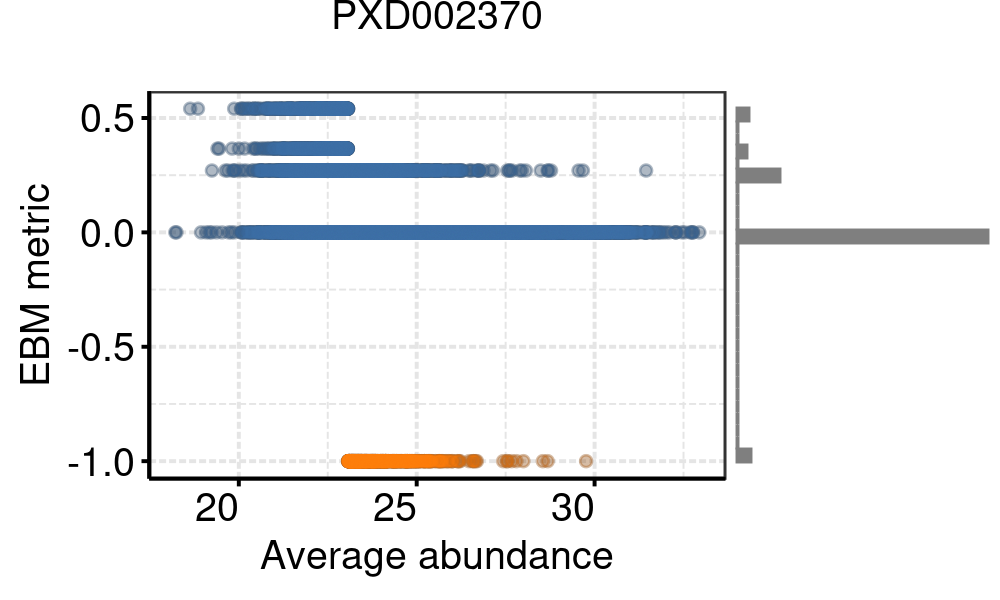

In [14]:
fig.size(3,5)


# EBM vs Ave abundance
p <- ggplot(ggdat, aes(x=AveExpr, y = metric)) +
  geom_point(alpha = 0.2) + 
  geom_point(data = subset(ggdat, metric == -1),alpha = 0.2, 
             color = "#FF7F0EFF") + 
  geom_point(data = subset(ggdat, metric != -1),alpha = 0.2, color = "#3E71A8") +
  #stat_bin_2d() +
  #geom_rug(sides = "b", alpha = 0.05) +
  theme_bw() +
  theme(axis.text.y = element_text(hjust = 1, size=14, color = "black"),
      axis.text.x = element_text(vjust = 1, hjust=1, size = 14, color= "black"),
                strip.text.x = element_text(size=14),
                plot.title = element_text(hjust = 0.5, size = 14),
      axis.title=element_text(size=14),
      panel.background = element_rect(fill = "white",
                                colour = "white",
                                size = 3, linetype = "solid"),
  panel.grid.major = element_line(#size = 3,
                                  linetype = 'longdash',
                                colour = "grey90"), 
  panel.grid.minor = element_line(#size = 3, 
                                  linetype = 'longdash',
                                colour = "grey90"),
      axis.line = element_line(colour = "black"),
      axis.ticks = element_line(colour = "black"),
      legend.text=element_text(size=12)
                #legend.position = "none"
     ) + labs(x='Average abundance', y = 'EBM metric', title = 'PXD002370')

p1 <- ggMarginal(p, type="histogram", margins = "y", 
                 fill = "gray50", color = "gray50", 
                 size = 2.1)


# png(file = "~/scatter_ebm_abundance_PXD002370.png",
#     width=5,height=3,units="in",res=1200)

# print(p1)
# dev.off()

p1

No NaN EBMs detected. Peptides are missing evenly across samples.

Switchted to 'hvp' method as final msImpute features




FALSE  TRUE 
12327   500 

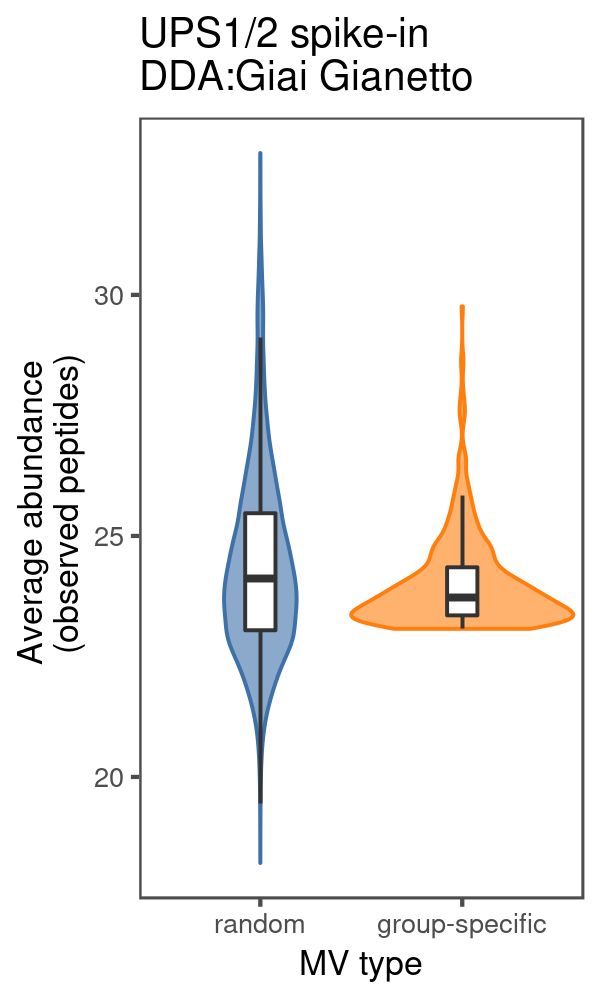

In [15]:
fig.size(5,3)
hdp <- selectFeatures(y_dda,
                      method="ebm", group = group)

#hdp
table(hdp$msImpute_feature) # msImpute features are peptides that exhibit condition-specific missing values

ebms <- hdp$EBM
ebms[hdp$msImpute_feature] <- -1
# hist(ebms)
# plot(hdp$AveExpr, ebms, pch = 16, cex = 0.3)



library(ggExtra)
library(ggthemes)

ggdat <- data.frame(hdp)
ggdat$metric <- ebms
ggdat$type <- ifelse(ggdat$metric == -1, "group-specific","random")
ggdat$type <- factor(ggdat$type, levels= c("random","group-specific"))



# png(file = paste0("revision_figures/violin_",dataset_name,".png"),
#     width=3.5,height=5.55, units="in",res=300)
pv <- ggplot(ggdat, aes(x=type, y = AveExpr)) + 
  geom_violin(aes(fill = type, color = type), alpha = 0.6, width = 1.1, show.legend = FALSE) +
  # stat_summary(fun.data=mean_sdl,
  #                geom="pointrange", color="black") +
  geom_boxplot(width=0.15, outlier.shape = NA) + 
  scale_fill_manual(values = c('random' = "#3E71A8", 'group-specific' = "#FF7F0EFF"))+
  scale_color_manual(values = c('random' = "#3E71A8", 'group-specific' = "#FF7F0EFF"))+
  labs(fill = '', y = 'Average abundance \n (observed peptides)', x = 'MV type',
       title = "UPS1/2 spike-in \nDDA:Giai Gianetto") +
  theme_few() 

print(pv)
# dev.off()

### Session information

In [16]:
sessionInfo()

R version 4.0.5 (2021-03-31)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS:   /stornext/System/data/apps/R/R-4.0.5/lib64/R/lib/libRblas.so
LAPACK: /stornext/System/data/apps/R/R-4.0.5/lib64/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] ggExtra_0.9         ggthemes_4.2.4      plotROC_2.2.1      
 [4] MSstats_3.22.1      msImpute_1.7.1      rrcovNA_0.4-15     
 [7] rrcov_1.6-0         robustbase_0.93-7   imputeLCMD_2.0     
[10] impute_1.64.0    